In [1]:
import modern_robotics as mr
import sympy as sp
from sympy import*
from sympy.physics.mechanics import dynamicsymbols, mechanics_printing
mechanics_printing()
from Utilities.symbolicFunctions import *
from Utilities.kukaKinematics import*



# TASK 2

### 1. Using the original Denavit-Hartenberg convention, determine the Denavit-Hartenberg parameters for the Agilus robot.

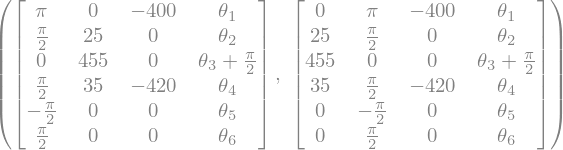

In [2]:
th1, th2, th3, th4, th5, th6 = dynamicsymbols('theta_1, theta_2, theta_3, theta_4, theta_5, theta_6')

config = sp.Matrix([[sp.pi,0,-400,th1],[sp.pi/2,25,0,th2],[0,455,0,th3 + sp.pi/2],[sp.pi/2, 35, -420, th4],[-sp.pi/2,0,0,th5],[sp.pi/2, 0, 0,th6]])

Sic_config = Matrix(sp.zeros(6,4))
Sic_config[:,0] = config[:,1]
Sic_config[:,1] = config[:,0]
Sic_config[:,2] = config[:,2]
Sic_config[:,3] = config[:,3]

config, Sic_config

#### Here, the first matrix represent the DH parameters in the same formate as in Modern Robotics. The second matrix represent the same table is illustrated as illustrated in Sicilliano. Theta are the free variables of each joint, where we add an additional pi/2 to the third joint to get a get the desired pose illustrated in the report. 

### 2. Determine the end-effector zero position configuration M ∈ SE(3) for the Agilus robot

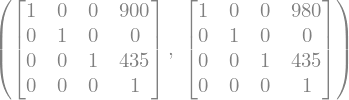

In [15]:
Mi = sp.Matrix([[sp.eye(4)]*6])

for i in range(6):
    if i == 2:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) * rotZ(-sp.pi/2) # We compansate for the rotation of pi/2 done when finding the D-H parameters 

    else:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) 

M_DH = sp.eye(4)
for n in range(5,-1,-1):
    M_DH = Mi[:,4*n:4*(n+1)] * M_DH

M_DH = M_DH * Tnb
M_DH, Me

####  Control: The M derived by visual inspection in Utilities/KukaKinematics and the Slist derived from the DH-formulation are in agreement. 
#### To compansate for the additional rotation of pi/2 in the table, we rotate the third joint with -pi/2 to get the zero-state configuration. As M represent the transformation matrix from the {s} frame to the end effector, and since the table from task one only trepresent the parameters of each joint, we add an additional T from the n'th link to the end-effector. 

### 3. Determine the space frame screw axes Si for the Agilus robot.

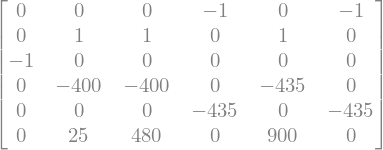

In [4]:
Ai = sp.Matrix([[0,-1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]) # This is a given matrix due to revolute joints

S_sp = sp.zeros(6)
for i in range(6):
    dot_sum = sp.eye(4)
    for n in range(i,-1,-1):
        dot_sum = Mi[:,4*n:4*(n+1)] * dot_sum
    S_skew = dot_sum * Ai * sp.Inverse(dot_sum)
    S_sp[0,i] = S_skew[2,1] 
    S_sp[1,i] = S_skew[0,2] 
    S_sp[2,i] = S_skew[1,0] 
    S_sp[3,i] = S_skew[0,3] 
    S_sp[4,i] = S_skew[1,3]
    S_sp[5,i] = S_skew[2,3] 

S_sp,Matrix(Slist)

####  Control: The Slist derived by visual inspection in Utilities/KukaKinematics and the Slist derived from the DH-formulation are in agreement. 

### 4. Determine the body-frame screw axes Bi for the Agilus robot

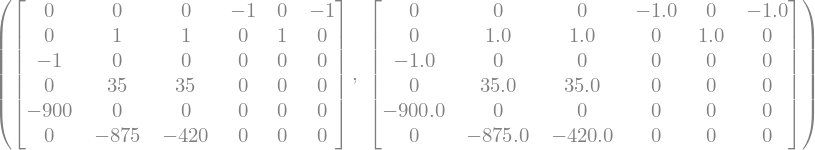

In [5]:
Mb = M6*Tnb                     #Mb = Tsb for robot in zero-config
M_inv = mr.TransInv(Mb)         #Finding inverse of M
Ad_M_inv = mr.Adjoint(M_inv)    #Computing [Ad_M^-1]

#Using B_i = [Ad_M^-1]S_i
Blist2 = sp.zeros(6,6)
for i in range(6):
     Blist2[:, i] = Ad_M_inv @ Slist[:, i]

Blist, Blist2


####  Control: The Blist derived by visual inspection in Utilities/KukaKinematics and calculated Blist are in agreement. 

### 5. Visualization 
#### Visualization using custom class in Utilities module. The big coordinate system being the {s}-frame and joint-frames oriented with z-axis along joint screw-axis.
#### Axis colours:
####    -Blue   -Z axis and joint screw-axis
####    -Red    -X axis
####    -Green  -Y axis

In [6]:
from Utilities.RobotClass import*
import numpy as np
from Utilities.kukaKinematics import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [16]:
#DH frames:

#Finding T01, T02..., from DH formulation Mi
Tlist_DH = np.zeros((6,4,4))      

T = sp.eye(4)
for i in range(6):          
    T = T * Mi[:,4*i:4*(i+1)]
    Tlist_DH[i] = T

#Visualize frames
Kuka_DH = Robot(Tlist_DH,['z','x','x','y','z','z'], Tne)
Kuka_DH.joints[5].set_colour([1,0,0])
Kuka_DH.draw_robot()


WebVisualizer(window_uid='window_5')

#### 

In [8]:
Kuka_DH.transform(Slist,[0,0,np.pi/2,0,0,0])
Kuka_DH.joints[2].set_colour([0,0,1])
T = Kuka_DH.current_config
Kuka_DH.draw_robot()

WebVisualizer(window_uid='window_1')

In [9]:
#Kuka robot visualized in zero-config, showing M (red) and all Screw axes as the joint frames' z-axis.
from Utilities.kukaKinematics import Mlist, Slist, Tnb

Kuka = Robot(Mlist, ['z', '-z', 'x', 'x', '-z','x'], Tnb) # With endeffector offset by Tnb

In [10]:
Kuka.joints[5].set_colour([1,0,0])
Kuka.draw_robot()

WebVisualizer(window_uid='window_2')

In [11]:
Kuka.transform(Slist,[0,0,np.pi/2,0,0,0])
T = Kuka.current_config

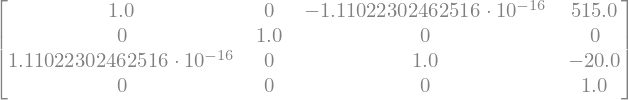

In [12]:
Tsb = T[5]
Tsb

In [13]:
Kuka.draw_robot()


WebVisualizer(window_uid='window_3')

In [14]:
Kuka.transform(Slist,[0,-np.pi/2,np.pi/2,0,0,0])
Kuka.draw_robot()

WebVisualizer(window_uid='window_4')